In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten
from tensorflow.keras.optimizers import Adam

from transformer.encoder import Encoder

In [3]:
config = {'num_heads': 12, 
          'vocab_size': 30522,
          'hidden_size': 128,
          'max_position_embeds': 512,
          'intermediate_size': 512,
          'dropout_p': 0.1,
          'input_size': (100,),
          'num_hidden_layers': 1}

## Get some toy data

The yelp sentence sentiment data set from Kaggle will do

In [15]:
rows = []
with open('yelp_labelled.txt', 'r') as FILE:
    while True:
        row = FILE.readline()
        if not row:
            break
        row = row.strip().split('\t')
        sentence = row[0]
        sentiment = int(row[1])
        rows.append({'sentence': sentence, 'sentiment': sentiment})
 
df = pd.DataFrame(rows, columns=['sentence', 'sentiment'])
df.head()

,sentence,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [34]:
df['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

### Get our toy vocabulary

In [17]:
vocab = {'<pad>': 0, '<unk>': 1}
index = 2
for s in df['sentence'].values:
    words = s.strip().split()
    for word in words:
        i = vocab.get(word)
        if i is None:
            vocab[word] = index
            index += 1

vocab_reverse = {value: key for key, value in vocab.items()}

config['vocab_size'] = len(vocab)


### Tokenize the sentences and split into x and y 

y will be the last token of each sequence, so we can try to predict it. But mostly we just want to see if our transformer encoder trains.

In [18]:
def tokenize(sent):
    tokens = [vocab[word] for word in sent.strip().split()]
    return tokens

x = list(map(tokenize, df['sentence']))
x = tf.keras.utils.pad_sequences(x)
y = df['sentiment'].values

config['input_size'] = (len(x[0]),)

print(f'Number of sentences: {df.shape[0]}')
print(f'Vocabulary size: {config["vocab_size"]}')
print(f'Max sentence length: {config["input_size"][0]}')

Number of sentences: 1000
Vocabulary size: 2971
Max sentence length: 32


In [19]:
x_train = x[:900]
y_train = y[:900]
x_test = x[900:]
y_test = y[900:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((900, 32), (900,), (100, 32), (100,))

## Try our transformer!

We'll just train our encoder by the task of predicting the last word of each sentence

In [30]:
clf = Sequential([InputLayer(input_shape=config['input_size']),
                  Encoder(config),
                  Flatten(),
                  Dense(1, activation='sigmoid')])

clf.build()
clf.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Encoder)           (None, 32, 128)           640232    
                                                                 
 flatten_3 (Flatten)         (None, 4096)              0         
                                                                 
 dense_159 (Dense)           (None, 1)                 4097      
                                                                 
Total params: 644,329
Trainable params: 644,329
Non-trainable params: 0
_________________________________________________________________


In [31]:
clf.compile(optimizer=Adam(lr=.00001), loss='binary_crossentropy', metrics=['accuracy'])
hist = clf.fit(x_train, 
               y_train,
               validation_data=(x_test, y_test),
               epochs=100)

Epoch 1/100
29/29 [==============================] - 12s 84ms/step - loss: 0.8304 - accuracy: 0.4933 - val_loss: 1.3387 - val_accuracy: 0.0600
Epoch 2/100
29/29 [==============================] - 1s 47ms/step - loss: 0.6554 - accuracy: 0.6033 - val_loss: 1.1400 - val_accuracy: 0.1500
Epoch 3/100
29/29 [==============================] - 1s 47ms/step - loss: 0.5113 - accuracy: 0.7522 - val_loss: 1.0406 - val_accuracy: 0.4400
Epoch 4/100
29/29 [==============================] - 1s 47ms/step - loss: 0.3230 - accuracy: 0.8767 - val_loss: 0.9680 - val_accuracy: 0.6000
Epoch 5/100
29/29 [==============================] - 1s 47ms/step - loss: 0.1496 - accuracy: 0.9456 - val_loss: 2.1086 - val_accuracy: 0.4700
Epoch 6/100
29/29 [==============================] - 1s 46ms/step - loss: 0.0641 - accuracy: 0.9811 - val_loss: 2.4061 - val_accuracy: 0.5500
Epoch 7/100
29/29 [==============================] - 1s 50ms/step - loss: 0.0374 - accuracy: 0.9867 - val_loss: 2.4676 - val_accuracy: 0.5600
Epoch

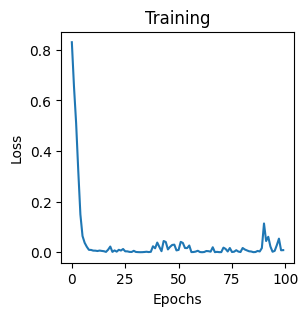

In [32]:
plt.figure(figsize=(3,3))
plt.plot(hist.history['loss'])
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [33]:
clf.evaluate(x_test, y_test, verbose=1)

4/4 [==============================] - 0s 11ms/step - loss: 5.1337 - accuracy: 0.6700


[5.133701801300049, 0.6700000166893005]